# Vermont

@author: eveomett AI for Redistricting, USF All data retrieved 05/23/24:
https://redistrictingdatahub.org/dataset/vermont-block-pl-94171-2020-by-table/

https://redistrictingdatahub.org/dataset/vest-2020-vermont-precinct-boundaries-and-election-results-shapefile/
https://redistrictingdatahub.org/dataset/vest-2018-vermont-precinct-and-election-results/
https://redistrictingdatahub.org/dataset/vest-2016-vermont-precinct-and-election-results/

https://redistrictingdatahub.org/dataset/2022-vermont-senate-districts-approved-plan/
https://redistrictingdatahub.org/dataset/2022-vermont-house-of-representatives-districts-approved-plan/

In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Vermont
state_ab = "vt"

## Data
1. Download all the data in directory "vt_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cvap_2022_cd/vt_cvap_2022_cd.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/Districts 2022-04-05.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/Districts 2022-04-05.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 24611/24611 [00:47<00:00, 512.99it/s] 


True

In [15]:
population_df.columns

Index(['GEOID20', 'SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'P0010001',
       'P0010002', 'P0010003', 'P0010004', 'P0010005',
       ...
       'P0040064', 'P0040065', 'P0040066', 'P0040067', 'P0040068', 'P0040069',
       'P0040070', 'P0040071', 'P0040072', 'P0040073'],
      dtype='object', length=223)

In [16]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [17]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [18]:
population_df.rename(columns=rename_dict, inplace = True)

## Read the vest 20 data

Now using it as a "base pricinct"

#### Check if vest20 can be used as base

In [19]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 284/284 [00:00<00:00, 501.51it/s]


In [20]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI', 'geometry'],
      dtype='object')

In [21]:
start_col = 3
vest_base_data = vest20
year = '20'

In [22]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

In [23]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [24]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 284/284 [00:02<00:00, 106.81it/s]


In [25]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [26]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

## Check if population agrees

In [27]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,643077,643077,True
HISP,HISP,15504,15504,True
NH_WHITE,NH_WHITE,573201,573201,True
NH_BLACK,NH_BLACK,8649,8649,True
NH_AMIN,NH_AMIN,1986,1986,True
NH_ASIAN,NH_ASIAN,11457,11457,True
NH_NHPI,NH_NHPI,170,170,True
NH_OTHER,NH_OTHER,2561,2561,True
NH_2MORE,NH_2MORE,29549,29549,True
H_WHITE,H_WHITE,4550,4550,True


### Add more vest data

In [28]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [29]:
vest16.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREIFUE', 'G16PREOLAR', 'G16PREOSAN',
       'G16PREOWRI', 'G16USSDLEA', 'G16USSRMIL', 'G16USSOERI', 'G16USSITRU',
       'G16USSODIA', 'G16USSOWRI', 'G16HALOWEL', 'G16HALOCLA', 'G16HALOWRI',
       'G16GOVDMIN', 'G16GOVRSCO', 'G16GOVOLEE', 'G16GOVOWRI', 'G16LTGDZUC',
       'G16LTGRBRO', 'G16LTGOWAR', 'G16LTGOWRI', 'G16TREOPEA', 'G16TREPSCH',
       'G16TREONGO', 'G16TREOWRI', 'G16SOSOCON', 'G16SOSOHER', 'G16SOSOWRI',
       'G16AUDDHOF', 'G16AUDRFEL', 'G16AUDOBRO', 'G16AUDOWRI', 'G16ATGDDON',
       'G16ATGRBUC', 'G16ATGOJAC', 'G16ATGOWRI', 'geometry'],
      dtype='object')

In [30]:
vest18.columns

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G18USSISAN', 'G18USSRZUP',
       'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL', 'G18USSIADE', 'G18USSISVI',
       'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI', 'G18HALDWEL', 'G18HALRTYN',
       'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI', 'G18GOVDHAL', 'G18GOVRSCO',
       'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI', 'G18GOVOMAR', 'G18GOVOPEY',
       'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR', 'G18LTGONGO', 'G18LTGOWRI',
       'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC', 'G18ATGOWRI', 'G18SOSDCON',
       'G18SOSRPAI', 'G18SOSOHER', 'G18SOSOWRI', 'G18TREDPEA', 'G18TRERMOR',
       'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN', 'G18AUDOBRO', 'G18AUDOWRI',
       'geometry'],
      dtype='object')

In [31]:
election_df = add_vest(vest18, election_df, '18', population_df, start_col)
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████| 284/284 [00:02<00:00, 106.21it/s]


population agrees


100%|██████████| 284/284 [00:02<00:00, 105.61it/s]

population agrees


##  Add the district data

In [32]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [33]:
election_df = add_district(send, "SEND", election_df, "ID")

100%|██████████| 16/16 [00:00<00:00, 48.90it/s]


In [34]:
election_df = add_district(hdist, "HDIST", election_df, "ID")

100%|██████████| 109/109 [00:00<00:00, 145.24it/s]


In [35]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG16D', 'ATG16O', 'ATG16R',
       'ATG18D', 'ATG18O', 'ATG18R', 'ATG20D', 'ATG20O', 'ATG20R', 'AUD16D',
       'AUD16O', 'AUD16R', 'AUD18D', 'AUD18O', 'AUD18R', 'AUD20O', 'BVAP',
       'COUNTYFP20', 'GOV16D', 'GOV16O', 'GOV16R', 'GOV18D', 'GOV18O',
       'GOV18R', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL16O', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'LTG16D',
       'LTG16O', 'LTG16R', 'LTG18O', 'LTG18R', 'LTG20D', 'LTG20O', 'LTG20R',
       'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O',
       'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS16O', 'SOS18D', 'SOS18O',
       'SOS18R', 'SOS20D', 'SOS20O', 'SOS20R', 'STATEFP20', 'TOTPOP', 'TRE16O',
       'TRE18D', 'TRE18O', 'TRE18R', 'TRE20D', 'TRE20O', 'TRE20R', 'USS16D',
       'USS16O', 'USS16

### Put the base precinct year after the precinct information column

In [36]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'COUNTYFP':'COUNTYFP'+year,
        'STATEFP':'STATEFP'+year,
        'NAME':'NAME'+year} 
election_df.rename(columns=base_columns, inplace = True)

In [37]:
# reorder the columns
fixed_columns = [
    'COUNTYFP'+year,
    'STATEFP'+year,
    'NAME'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [38]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

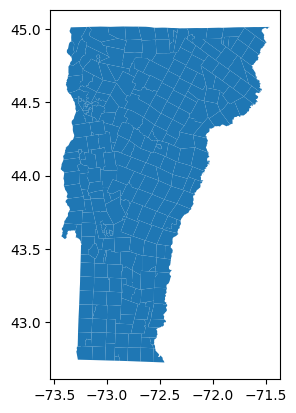

In [39]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()